# AnnNet — End‑to‑End Stress Notebook

**Goal:** build a realistic, multi‑slice biological interaction graph with **tens of thousands** of vertices and a mix of **binary edges, hyperedges, and vertex–edge (edge‑entity) links**, then **exercise every public API**: slices, presence queries, propagation (`shared` / `all`), views, analytics, set operations, aggregations, subgraph/copy, deletions, auditing, and memory usage.

In [1]:
# Robust import of AnnNet
import os
import random
import sys
from time import perf_counter

sys.path.insert(0, os.path.abspath(".."))  # must be the parent folder that CONTAINS 'annnet'

from annnet.core.graph import AnnNet

import polars as pl

In [2]:
# Parameters — choose a scale
# - DEMO runs fast on laptops
# - STRESS creates 10^4–10^5 scale objects; adjust upward to your machine limits

SCALE = "MID"  # "DEMO" or "STRESS"

if SCALE.upper() == "DEMO":
    N_PROTEINS = 5_00
    N_TRANSCRIPTS = 2_00
    N_METABOLITES = 1_00
    N_EDGE_ENTITIES = 40
    N_BIN_EDGES = 25_00  # binary protein-protein interactions (base slice)
    N_HYPER_COMPLEX = 1_00  # undirected complexes
    N_HYPER_CASCADE = 1_00  # directed signaling cascades
    N_vertex_EDGE_BIDIR = 2_00  # vertex<->edge-entity links (counted as pairs)
elif SCALE.upper() == "MID":
    N_PROTEINS = 10_000
    N_TRANSCRIPTS = 5_000
    N_METABOLITES = 20_000
    N_EDGE_ENTITIES = 300
    N_BIN_EDGES = 45_000
    N_HYPER_COMPLEX = 4_000
    N_HYPER_CASCADE = 3_000
    N_vertex_EDGE_BIDIR = 5_000
else:
    N_PROTEINS = 200_000
    N_TRANSCRIPTS = 50_000
    N_METABOLITES = 20_000
    N_EDGE_ENTITIES = 20_500
    N_BIN_EDGES = 800_000
    N_HYPER_COMPLEX = 20_000  # use commas? We'll correct below to int
    N_HYPER_CASCADE = 20_000
    N_vertex_EDGE_BIDIR = 15_000


nn = N_PROTEINS + N_TRANSCRIPTS + N_METABOLITES
ne = N_BIN_EDGES + N_EDGE_ENTITIES + N_HYPER_COMPLEX + N_HYPER_CASCADE + N_vertex_EDGE_BIDIR
# fix typo for N_HYPER_COMPLEX in STRESS case
if isinstance(N_HYPER_COMPLEX, tuple):
    N_HYPER_COMPLEX = 20000

sliceS = ["Healthy", "Stressed", "Disease", "DrugA", "DrugB"]
ORDERED_FOR_TEMPORAL = ["Healthy", "Stressed", "Disease", "DrugA", "DrugB"]

# How many parallel edges to create as duplicates between random pairs
N_PARALLEL_DUPES = max(1, N_BIN_EDGES // 20)

# Fraction of vertices seeded into each non-default slice (to make propagate='shared'/'all' meaningful)
SEED_FRAC_PER_slice = 0.75

In [3]:
# Helpers


def rand_weight(base=1.0, jitter=0.5):
    # positive weight with variability
    w = base + (random.random() - 0.5) * 2 * jitter
    return max(0.01, w)


def try_to_pandas(df):
    if df is None:
        return None
    if "polars" in type(df).__module__.lower():
        return df.to_pandas() if hasattr(df, "to_pandas") else None
    return df  # assume already pandas-like


def head_df(df, n=5):
    p = try_to_pandas(df)
    return p.head(n) if p is not None else None

In [4]:
# Build graph & slices
t0 = perf_counter()
G = AnnNet(directed=True)

for lid in sliceS:
    G.add_slice(lid, desc=f"condition={lid}")
G.set_active_slice(sliceS[0])
build_slices_time = perf_counter() - t0
print("slices ready:", G.list_slices(), "active:", G.get_active_slice())

slices ready: ['Healthy', 'Stressed', 'Disease', 'DrugA', 'DrugB'] active: Healthy


In [5]:
G.X().shape

(0, 0)

In [6]:
# ---- progress helpers ----
from time import perf_counter

try:
    from tqdm.auto import tqdm  # uses notebook bar if available

    _TQDM = True
except Exception:
    _TQDM = False


def prog_iter(it, total=None, desc="", mininterval=0.25):
    """Wrap any iterable with a progress display (tqdm if available, else no-op)."""
    if _TQDM:
        return tqdm(it, total=total, desc=desc, mininterval=mininterval, leave=False)
    return it


def batched(iterable, batch_size):
    """Yield lists of size <= batch_size (Py<3.12 compatible)."""
    buf = []
    for x in iterable:
        buf.append(x)
        if len(buf) == batch_size:
            yield buf
            buf = []
    if buf:
        yield buf

/home/l1boll/miniconda3/envs/myenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
import numpy as np

rng = np.random.default_rng(42)

t = perf_counter()

proteins = [f"P{i}" for i in range(1, N_PROTEINS + 1)]
transcripts = [f"T{i}" for i in range(1, N_TRANSCRIPTS + 1)]
metabolites = [f"M{i}" for i in range(1, N_METABOLITES + 1)]
edge_entities = [f"EE{i}" for i in range(1, N_EDGE_ENTITIES + 1)]

# --- Seed vertices in "Healthy" ---
kinase_mask = rng.random(len(proteins)) < 0.15
G.add_vertices_bulk(
    (
        {"vertex_id": p, "kind": "protein", **({"family": "kinase"} if km else {})}
        for p, km in zip(proteins, kinase_mask)
    ),
    slice="Healthy",
)
G.add_vertices_bulk(({"vertex_id": t, "kind": "transcript"} for t in transcripts), slice="Healthy")
G.add_vertices_bulk(({"vertex_id": m, "kind": "metabolite"} for m in metabolites), slice="Healthy")

# --- Edge-entities in "Healthy" (bulk) ---
pathways = np.array(["glycolysis", "tca", "mapk", "pi3k"])
drawn_pathways = pathways[rng.integers(0, len(pathways), size=len(edge_entities))]
G.add_edge_entities_bulk(
    (
        {"edge_entity_id": ee, "role": "enzyme", "pathway": pw}
        for ee, pw in zip(edge_entities, drawn_pathways)
    ),
    slice="Healthy",
)

# --- Seed presence into other slices (bulk per slice) ---
p_keep = SEED_FRAC_PER_slice
for lid in sliceS[1:]:
    pmask = rng.random(len(proteins)) < p_keep
    tmask = rng.random(len(transcripts)) < p_keep
    mmask = rng.random(len(metabolites)) < p_keep

    G.add_vertices_bulk(
        ({"vertex_id": p, "kind": "protein"} for p, keep in zip(proteins, pmask) if keep),
        slice=lid,
    )
    G.add_vertices_bulk(
        ({"vertex_id": t, "kind": "transcript"} for t, keep in zip(transcripts, tmask) if keep),
        slice=lid,
    )
    G.add_vertices_bulk(
        ({"vertex_id": m, "kind": "metabolite"} for m, keep in zip(metabolites, mmask) if keep),
        slice=lid,
    )

build_vertices_time = perf_counter() - t
print(
    "vertices done. #vertices:",
    G.number_of_vertices(),
    "Edge-entities:",
    sum(1 for k, v in G.entity_types.items() if v == "edge"),
    "time(s)=",
    round(build_vertices_time, 3),
)

vertices done. #vertices: 35000 Edge-entities: 300 time(s)= 0.497


In [8]:
# Binary edges (PPIs mostly among proteins), defined in Healthy then sliceed variants
from time import perf_counter

t = perf_counter()

# ---------- 1) Bulk create binary edges on "Healthy" ----------
pairs = []
need = N_BIN_EDGES
names = proteins
n = len(names)

# Generate candidate pairs quickly; reject self-loops
while len(pairs) < need:
    k = min(need - len(pairs), max(1024, need // 4))
    us = random.choices(names, k=k)
    vs = random.choices(names, k=k)
    for u, v in zip(us, vs):
        if u != v:
            pairs.append((u, v))
        if len(pairs) == need:
            break

dirs = [random.random() < 0.8 for _ in range(need)]
ws = [rand_weight(1.2, 0.6) for _ in range(need)]

bulk = [
    {
        "source": u,
        "target": v,
        "weight": w,
        "edge_directed": d,
        "edge_type": "regular",
        "slice": "Healthy",
    }
    for (u, v), w, d in zip(pairs, ws, dirs)
]
ppis = G.add_edges_bulk(bulk, slice="Healthy")  # list of edge_ids

# ---------- 2) Bulk add parallel dupes ----------
if ppis and N_PARALLEL_DUPES > 0:
    chosen = random.choices(ppis, k=N_PARALLEL_DUPES)
    par_edges = []
    for eid in chosen:
        u, v, _ = G.edge_definitions[eid]
        par_edges.append(
            {
                "source": u,
                "target": v,
                "weight": rand_weight(1.0, 0.3),
                "edge_type": "regular",
                "slice": "Healthy",
            }
        )
    G.add_edges_bulk(par_edges, slice="Healthy")

# ---------- 3) Bulk per-slice variants ----------
base_w = {eid: G.edge_weights[eid] for eid in ppis}

for lid in sliceS[1:]:
    # Add all PPI edges to this slice in one shot
    G.add_edges_to_slice_bulk(lid, ppis)

    # Compute modifiers and upsert all weights for this slice at once
    weights_rows = []
    for eid in ppis:
        bw = base_w[eid]
        factor = {
            "Stressed": rand_weight(1.10, 0.10),
            "Disease": (0.7 if random.random() < 0.4 else rand_weight(1.30, 0.15)),
            "DrugA": rand_weight(0.9, 0.25),
            "DrugB": rand_weight(1.2, 0.20),
        }[lid]
        weights_rows.append((eid, {"weight": bw * factor, "note": f"slice={lid}"}))

    G.set_edge_slice_attrs_bulk(lid, weights_rows)

build_binary_time = perf_counter() - t
print(
    "Binary edges built:",
    len(ppis),
    "total edges now:",
    G.number_of_edges(),
    "time(s)=",
    round(build_binary_time, 3),
)

Binary edges built: 45000 total edges now: 47250 time(s)= 1.633


In [9]:
# Propagation semantics via add_edge(..., propagate=...)
t = perf_counter()
# Ensure varied vertex presence across slices for a few pairs
pairs = [(random.choice(proteins), random.choice(transcripts)) for _ in range(2000)]
for u, v in pairs:
    # 'shared': only slices where both endpoints already present
    G.add_edge(
        u, v, slice="Healthy", edge_type="regular", weight=rand_weight(0.8, 0.2), propagate="shared"
    )
pairs2 = [(random.choice(proteins), random.choice(metabolites)) for _ in range(2000)]
for u, v in pairs2:
    # 'all': appears everywhere either endpoint exists (pulls other endpoint in)
    G.add_edge(
        u, v, slice="Healthy", edge_type="regular", weight=rand_weight(0.8, 0.2), propagate="all"
    )

build_propagation_time = perf_counter() - t
print("Propagation examples added (shared/all).")

Propagation examples added (shared/all).


In [10]:
# Hyperedges: undirected complexes, directed cascades
t = perf_counter()

# ------------------ Complexes ------------------
complex_payload = [
    {
        "members": random.sample(proteins, random.choice([3, 4, 5, 6])),
        "slice": "Healthy",
        "weight": rand_weight(1.0, 0.2),
        "attributes": {"tag": "complex"},
        # "propagate": "all",   # uncomment if you want auto-propagation
    }
    for _ in range(N_HYPER_COMPLEX)
]

complex_ids = G.add_hyperedges_bulk(complex_payload)


# ------------------ Cascades ------------------
cascade_payload = []
tries = 0
while len(cascade_payload) < N_HYPER_CASCADE and tries < N_HYPER_CASCADE * 5:
    tries += 1
    head = set(random.sample(proteins, random.choice([1, 2])))
    tail = set(random.sample(proteins, random.choice([2, 3, 4])))
    if head & tail:
        continue

    cascade_payload.append(
        {
            "head": list(head),
            "tail": list(tail),
            "slice": "Healthy",
            "weight": rand_weight(1.0, 0.4),
            "attributes": {"tag": "cascade"},
            # "propagate": "all",   # if desired
        }
    )

cascade_ids = G.add_hyperedges_bulk(cascade_payload)

build_hyper_time = perf_counter() - t
print("Hyperedges built:", len(complex_ids), "complexes ;", len(cascade_ids), "cascades")
print("time(s)=",
    round(build_hyper_time, 3),
)

Hyperedges built: 4000 complexes ; 3000 cascades
time(s)= 0.352


In [11]:
print("Building hybrid vertex–edge reactions...")

t = perf_counter()

for _ in range(N_vertex_EDGE_BIDIR):
    ee = random.choice(edge_entities)
    s  = random.choice(proteins + transcripts + metabolites)
    tvertex = random.choice(proteins + transcripts + metabolites)

    # Ensure entity exists in the slice (cheap if already added)
    G.add_edge_entity(ee, slice="Healthy")

    # Vertex → Edge-Entity
    eid1 = G.add_edge(
        s, ee,
        slice="Healthy",
        weight=rand_weight(1.0, 0.5)
    )

    # Edge-Entity → Vertex
    eid2 = G.add_edge(
        ee, tvertex,
        slice="Healthy",
        weight=rand_weight(1.0, 0.5)
    )

    # Reflect edges to all other slices
    for lid in sliceS[1:]:
        G.add_edge_to_slice(lid, eid1)
        G.add_edge_to_slice(lid, eid2)

build_time = perf_counter() - t

# ----------------------------
# Results
# ----------------------------
print(f"Hybrid vertex–edge reactions added: {N_vertex_EDGE_BIDIR}")
print(f"Total time: {build_time:.4f} seconds")
print(f"Average per reaction: {build_time / N_vertex_EDGE_BIDIR:.6f} seconds")
print(f"AnnNet entities: {len(G.entity_to_idx)}")
print(f"AnnNet edges:    {len(G.edge_to_idx)}")

build_vertexedge_time = perf_counter() - t

Building hybrid vertex–edge reactions...
Hybrid vertex–edge reactions added: 5000
Total time: 2.0160 seconds
Average per reaction: 0.000403 seconds
AnnNet entities: 35300
AnnNet edges:    68250


In [12]:
# Sanity & counts
print("vertices:", G.number_of_vertices(), "Edges:", G.number_of_edges())
assert G.number_of_vertices() > 0 and G.number_of_edges() > 0

# Edge-entity count
edge_entity_count = sum(
    1 for _id, et in G.entity_types.items() if et == "edge" and _id in set(edge_entities)
)
print("Edge-entities:", edge_entity_count)
assert edge_entity_count == len(edge_entities)

vertices: 35000 Edges: 68250
Edge-entities: 300


In [13]:
# Views & Top edges per slice
try:
    for lid in sliceS:
        EV = G.edges_view(slice=lid, resolved_weight=True)
        print(
            f"[{lid}] edges_view rows:", getattr(EV, "height", getattr(EV, "shape", ["?", "?"])[0])
        )
        # filter binary only, sort by effective weight
        if pl is not None and isinstance(EV, pl.DataFrame):
            top = (
                EV.filter(pl.col("kind") == "binary")
                .sort("effective_weight", descending=True)
                .select(["edge_id", "source", "target", "effective_weight"])
                .head(5)
            )
            print(f"Top 5 binary edges in {lid}:\n", top)
        else:
            # Try pandas-like
            try:
                df = EV
                if hasattr(df, "query"):
                    bf = (
                        df.query("kind == 'binary'")
                        .sort_values("effective_weight", ascending=False)
                        .head(5)
                    )
                    print(bf[["edge_id", "source", "target", "effective_weight"]])
            except Exception:
                pass
except Exception as e:
    print("edges_view failed softly:", e)

try:
    NV = G.vertices_view()
    LV = G.slices_view()
    print("vertices view cols:", getattr(NV, "columns", None))
    print("slices view cols:", getattr(LV, "columns", None))
except Exception as e:
    print("vertices_view/slices_view failed softly:", e)

[Healthy] edges_view rows: 68250
Top 5 binary edges in Healthy:
 shape: (5, 4)
┌────────────┬────────┬────────┬──────────────────┐
│ edge_id    ┆ source ┆ target ┆ effective_weight │
│ ---        ┆ ---    ┆ ---    ┆ ---              │
│ str        ┆ str    ┆ str    ┆ f64              │
╞════════════╪════════╪════════╪══════════════════╡
│ edge_18055 ┆ P735   ┆ P7591  ┆ 1.799999         │
│ edge_12232 ┆ P7938  ┆ P6743  ┆ 1.799998         │
│ edge_29815 ┆ P6998  ┆ P1862  ┆ 1.799945         │
│ edge_7657  ┆ P2940  ┆ P7214  ┆ 1.7999           │
│ edge_36021 ┆ P8375  ┆ P6289  ┆ 1.799883         │
└────────────┴────────┴────────┴──────────────────┘
[Stressed] edges_view rows: 68250
Top 5 binary edges in Stressed:
 shape: (5, 4)
┌────────────┬────────┬────────┬──────────────────┐
│ edge_id    ┆ source ┆ target ┆ effective_weight │
│ ---        ┆ ---    ┆ ---    ┆ ---              │
│ str        ┆ str    ┆ str    ┆ f64              │
╞════════════╪════════╪════════╪══════════════════╡
│ edge_5

In [14]:
# Presence queries
any_e = next(iter(G.edge_to_idx.keys()))
print("Edge presence across slices:", G.edge_presence_across_slices(edge_id=any_e))

any_p = random.choice(proteins)
print("vertex presence across slices:", G.vertex_presence_across_slices(any_p))

# Hyperedge presence by members and head/tail
if complex_ids:
    m = random.choice(complex_ids)
    members = G.hyperedge_definitions[m].get("members", set())
    if members:
        print(
            "Hyperedge presence (members):",
            G.hyperedge_presence_across_slices(members=set(members)),
        )
if cascade_ids:
    h = random.choice(cascade_ids)
    hd = G.hyperedge_definitions[h]
    if hd.get("head") and hd.get("tail"):
        print(
            "Hyperedge presence (head/tail):",
            G.hyperedge_presence_across_slices(head=set(hd["head"]), tail=set(hd["tail"])),
        )

Edge presence across slices: ['Healthy', 'Stressed', 'Disease', 'DrugA', 'DrugB']
vertex presence across slices: ['Healthy', 'Stressed', 'Disease', 'DrugA', 'DrugB']
Hyperedge presence (members): {'Healthy': ['edge_55191']}
Hyperedge presence (head/tail): {'Healthy': ['edge_56719']}


In [15]:
# Traversal
q = random.choice(proteins)
print(f"Neighbors({q}) sample:", G.neighbors(q)[:10])
print(f"Out({q}) sample:", G.out_neighbors(q)[:10])
print(f"In({q}) sample:", G.in_neighbors(q)[:10])

Neighbors(P1195) sample: ['P3082', 'P8394', 'P4278', 'P6996', 'P149', 'P3742', 'P3625', 'P4658', 'P5482', 'P7969']
Out(P1195) sample: ['P3082', 'P8394', 'P4278', 'P6996', 'P149', 'P3742', 'P3625', 'P4658', 'P5482', 'P7969']
In(P1195) sample: ['P3082', 'P7969', 'P4278', 'P6996', 'P149', 'P3742', 'P9182', 'P5511', 'P3625', 'P5952']


In [18]:
# slice analytics, conserved/specific, temporal
stats = G.slice_statistics()
print("slice stats keys:", list(stats.keys())[:5])

conserved = G.conserved_edges(min_slices=len(sliceS))
print("Conserved edges (present in all slices):", len(conserved))

disease_specific = G.slice_specific_edges("Disease")
print("Disease-specific edges:", len(disease_specific))

changes_e = G.temporal_dynamics(ORDERED_FOR_TEMPORAL, metric="edge_change")
changes_n = G.temporal_dynamics(ORDERED_FOR_TEMPORAL, metric="vertex_change")
print("Temporal edge changes entries:", len(changes_e), "vertex changes entries:", len(changes_n))

slice stats keys: ['Healthy', 'Stressed', 'Disease', 'DrugA', 'DrugB']
Conserved edges (present in all slices): 58993
Disease-specific edges: 0
Temporal edge changes entries: 4 vertex changes entries: 4


In [21]:
# slice set ops and derived slices
u = G.slice_union(["Healthy", "Stressed"])
i = G.slice_intersection(["Healthy", "Stressed"])
d = G.slice_difference("Healthy", "Stressed")
print("Union edges>=intersection edges:", len(u["edges"]) >= len(i["edges"]))

lid_u = G.create_slice_from_operation("ttHS_union", u, desc="H∪S")
lid_i = G.create_slice_from_operation("ttHS_intersection", i, desc="H∩S")
lid_d = G.create_slice_from_operation("ttH_minus_S", d, desc="H\\S")
print(
    "Derived slices exist:",
    G.has_slice("HS_union"),
    G.has_slice("HS_intersection"),
    G.has_slice("H_minus_S"),
)

# Aggregations
G.create_aggregated_slice(["Healthy", "Stressed"], "tAgg_union", method="union", tag="agg_u")
G.create_aggregated_slice(
    ["Healthy", "Stressed"], "tAgg_intersection", method="intersection", tag="agg_i"
)
print("Aggregated slices added.")

Union edges>=intersection edges: True
Derived slices exist: True True True
Aggregated slices added.


In [22]:
# Edge list & global counts
el = G.edge_list()
print("Edge list tuple length check (u,v,kind,id):", all(len(t) == 4 for t in el))
print("Global entity/edge counts:", G.global_entity_count(), G.global_edge_count())

Edge list tuple length check (u,v,kind,id): True
Global entity/edge counts: 35300 68550


In [28]:
# Subgraph & copy
t =  perf_counter()

SG = G.subgraph_from_slice("DrugB", resolve_slice_weights=True)
print("DrugB subgraph vertices/edges:", SG.number_of_vertices(), SG.number_of_edges())

subgraph_time = perf_counter() - t
print(f"subgraph time {subgraph_time}")

DrugB subgraph vertices/edges: 30916 58518
subgraph time 1.1374964719943819


In [29]:
t =  perf_counter()

CP = G.copy(history= True)
# quick consistency checks
assert set(CP.vertices()) == set(G.vertices())
assert set(CP.edges()) == set(G.edges())
any_hyper = next(e for e, k in G.edge_kind.items() if k == "hyper")
assert CP.edge_kind.get(any_hyper) == "hyper"
for lid in G.list_slices(include_default=True):
    assert CP._slices[lid]["vertices"] == G._slices[lid]["vertices"]
    assert CP._slices[lid]["edges"] == G._slices[lid]["edges"]
print("Deep copy OK.")

copy_time = perf_counter() - t
print(f"copy time {copy_time}")

Deep copy OK.
copy time 0.5144524070055922


In [30]:
# Removals: drop a slice of vertices/edges

t =  perf_counter()
# Drop ~1% of proteins
drop_vertices = random.sample(proteins, max(1, len(proteins) // 100))
G.remove_vertices(drop_vertices)  # one pass
remove_vertices_t = perf_counter() - t
print("vert", remove_vertices_t, "s")

t =  perf_counter()
# Drop up to 500 edges
drop_edges = list(G.edge_to_idx.keys())[: min(500, len(G.edge_to_idx))]
G.remove_edges(drop_edges)  # one pass
remove_edges_t =  perf_counter() - t
print("edge", remove_edges_t, "s")


print("After removals: vertices=", G.number_of_vertices(), "edges=", G.number_of_edges())

vert 1.7236467090042424 s
edge 0.892471174003731 s
After removals: vertices= 34900 edges= 66400


In [31]:
# Audit & memory
audit = G.audit_attributes()
mem_bytes = G.memory_usage()
print("Audit keys:", list(audit.keys())[:10])
print("Approx memory usage (bytes):", int(mem_bytes))

Audit keys: ['extra_vertex_rows', 'extra_edge_rows', 'missing_vertex_rows', 'missing_edge_rows', 'invalid_edge_slice_rows']
Approx memory usage (bytes): 19218755


if SCALE.upper() == "DEMO":
    N_PROTEINS = 5_00
    N_TRANSCRIPTS = 2_00
    N_METABOLITES = 1_00
    N_EDGE_ENTITIES = 40
    N_BIN_EDGES = 25_00  # binary protein-protein interactions (base slice)
    N_HYPER_COMPLEX = 1_00  # undirected complexes
    N_HYPER_CASCADE = 1_00  # directed signaling cascades
    N_vertex_EDGE_BIDIR = 2_00  # vertex<->edge-entity links (counted as pairs)
elif SCALE.upper() == "MID":
    N_PROTEINS = 10_000
    N_TRANSCRIPTS = 5_000
    N_METABOLITES = 20_000
    N_EDGE_ENTITIES = 300
    N_BIN_EDGES = 45_000
    N_HYPER_COMPLEX = 4_000
    N_HYPER_CASCADE = 3_000
    N_vertex_EDGE_BIDIR = 5_000
else:
    N_PROTEINS = 200_000
    N_TRANSCRIPTS = 50_000
    N_METABOLITES = 20_000
    N_EDGE_ENTITIES = 20_500
    N_BIN_EDGES = 800_000
    N_HYPER_COMPLEX = 20_000  # use commas? We'll correct below to int
    N_HYPER_CASCADE = 20_000
    N_vertex_EDGE_BIDIR = 15_000
Build timings (seconds)                 stage   seconds
0  build_binary_edges  1.632707
1   

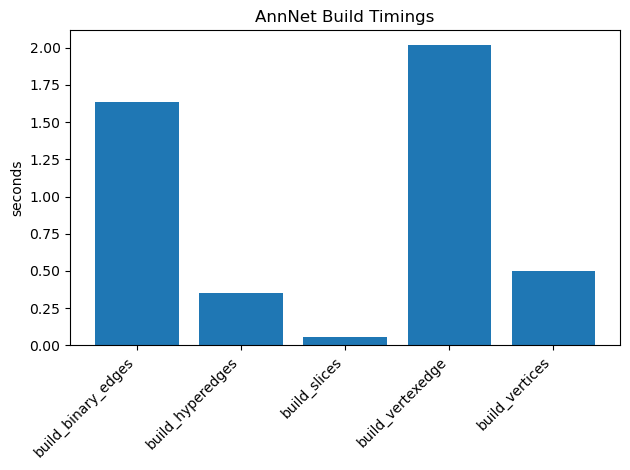

In [36]:
# Timing summary
import pandas as pd

timings = {
    "build_slices": build_slices_time,
    "build_vertices": build_vertices_time,
    "build_binary_edges": build_binary_time,
    "build_hyperedges": build_hyper_time,
    "build_vertexedge": build_vertexedge_time,
}

print("""if SCALE.upper() == "DEMO":
    N_PROTEINS = 5_00
    N_TRANSCRIPTS = 2_00
    N_METABOLITES = 1_00
    N_EDGE_ENTITIES = 40
    N_BIN_EDGES = 25_00  # binary protein-protein interactions (base slice)
    N_HYPER_COMPLEX = 1_00  # undirected complexes
    N_HYPER_CASCADE = 1_00  # directed signaling cascades
    N_vertex_EDGE_BIDIR = 2_00  # vertex<->edge-entity links (counted as pairs)
elif SCALE.upper() == "MID":
    N_PROTEINS = 10_000
    N_TRANSCRIPTS = 5_000
    N_METABOLITES = 20_000
    N_EDGE_ENTITIES = 300
    N_BIN_EDGES = 45_000
    N_HYPER_COMPLEX = 4_000
    N_HYPER_CASCADE = 3_000
    N_vertex_EDGE_BIDIR = 5_000
else:
    N_PROTEINS = 200_000
    N_TRANSCRIPTS = 50_000
    N_METABOLITES = 20_000
    N_EDGE_ENTITIES = 20_500
    N_BIN_EDGES = 800_000
    N_HYPER_COMPLEX = 20_000  # use commas? We'll correct below to int
    N_HYPER_CASCADE = 20_000
    N_vertex_EDGE_BIDIR = 15_000""")

df = pd.DataFrame(sorted(timings.items(), key=lambda x: x[0]), columns=["stage", "seconds"])

print("Build timings (seconds)", df)

# Simple chart
import matplotlib.pyplot as plt

plt.figure()
plt.bar(df["stage"], df["seconds"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("seconds")
plt.title("AnnNet Build Timings")
plt.tight_layout()
plt.show()

In [37]:
from pathlib import Path
out_dir = Path('stress'); out_dir.mkdir(exist_ok=True, parents=True)
#demo_path = out_dir/'demo.annnet'
demo_path = "stress.annnet"
t = perf_counter()

G.write(demo_path, overwrite=True)  # lossless save
print('Wrote:', demo_path)

writet = perf_counter() - t
print ("write time: ", writet)

Wrote: stress.annnet
write time:  2.055940282996744


In [38]:
import annnet
# Round-trip check
t = perf_counter()
G2 = annnet.AnnNet.read(demo_path)
readt = perf_counter() - t
print ("read time: ", readt)


print('Round-trip OK?', (G2.num_vertices, G2.num_edges) == (G.num_vertices, G.num_edges))



read time:  1.1429744359993492
Round-trip OK? True


In [70]:
SCALE = "MID"  # "DEMO" or "STRESS"

def fullrun(SCALE = "MID"):
    # Robust import of AnnNet
    import os
    import random
    import sys
    from time import perf_counter
    
    sys.path.insert(0, os.path.abspath(".."))  # must be the parent folder that CONTAINS 'annnet'
    
    from annnet.core.graph import AnnNet
    
    import polars as pl
    
    
    # Parameters — choose a scale
    # - DEMO runs fast on laptops
    # - STRESS creates 10^4–10^5 scale objects; adjust upward to your machine limits
    
    
    if SCALE.upper() == "DEMO":
        N_PROTEINS = 5_00
        N_TRANSCRIPTS = 2_00
        N_METABOLITES = 1_00
        N_EDGE_ENTITIES = 40
        N_BIN_EDGES = 25_00  # binary protein-protein interactions (base slice)
        N_HYPER_COMPLEX = 1_00  # undirected complexes
        N_HYPER_CASCADE = 1_00  # directed signaling cascades
        N_vertex_EDGE_BIDIR = 2_00  # vertex<->edge-entity links (counted as pairs)
    elif SCALE.upper() == "MID":
        N_PROTEINS = 10_000
        N_TRANSCRIPTS = 5_000
        N_METABOLITES = 20_000
        N_EDGE_ENTITIES = 300
        N_BIN_EDGES = 45_000
        N_HYPER_COMPLEX = 4_000
        N_HYPER_CASCADE = 3_000
        N_vertex_EDGE_BIDIR = 5_000
    else:
        N_PROTEINS = 200_000
        N_TRANSCRIPTS = 50_000
        N_METABOLITES = 20_000
        N_EDGE_ENTITIES = 20_500
        N_BIN_EDGES = 800_000
        N_HYPER_COMPLEX = 20_000  # use commas? We'll correct below to int
        N_HYPER_CASCADE = 20_000
        N_vertex_EDGE_BIDIR = 15_000
    
    
    nn = N_PROTEINS + N_TRANSCRIPTS + N_METABOLITES
    ne = N_BIN_EDGES + N_EDGE_ENTITIES + N_HYPER_COMPLEX + N_HYPER_CASCADE + N_vertex_EDGE_BIDIR
    # fix typo for N_HYPER_COMPLEX in STRESS case
    if isinstance(N_HYPER_COMPLEX, tuple):
        N_HYPER_COMPLEX = 20000
    
    sliceS = ["Healthy", "Stressed", "Disease", "DrugA", "DrugB"]
    ORDERED_FOR_TEMPORAL = ["Healthy", "Stressed", "Disease", "DrugA", "DrugB"]
    
    # How many parallel edges to create as duplicates between random pairs
    N_PARALLEL_DUPES = max(1, N_BIN_EDGES // 20)
    
    # Fraction of vertices seeded into each non-default slice (to make propagate='shared'/'all' meaningful)
    SEED_FRAC_PER_slice = 0.75
    
    # Helpers
    
    
    def rand_weight(base=1.0, jitter=0.5):
        # positive weight with variability
        w = base + (random.random() - 0.5) * 2 * jitter
        return max(0.01, w)
    
    
    def try_to_pandas(df):
        if df is None:
            return None
        if "polars" in type(df).__module__.lower():
            return df.to_pandas() if hasattr(df, "to_pandas") else None
        return df  # assume already pandas-like
    
    
    def head_df(df, n=5):
        p = try_to_pandas(df)
        return p.head(n) if p is not None else None
    
    # Build graph & slices
    t0 = perf_counter()
    G = AnnNet(directed=True)
    
    for lid in sliceS:
        G.add_slice(lid, desc=f"condition={lid}")
    G.set_active_slice(sliceS[0])
    build_slices_time = perf_counter() - t0
    print("slices ready:", G.list_slices(), "active:", G.get_active_slice())
    
    # ---- progress helpers ----
    from time import perf_counter
    
    try:
        from tqdm.auto import tqdm  # uses notebook bar if available
    
        _TQDM = True
    except Exception:
        _TQDM = False
    
    
    def prog_iter(it, total=None, desc="", mininterval=0.25):
        """Wrap any iterable with a progress display (tqdm if available, else no-op)."""
        if _TQDM:
            return tqdm(it, total=total, desc=desc, mininterval=mininterval, leave=False)
        return it
    
    
    def batched(iterable, batch_size):
        """Yield lists of size <= batch_size (Py<3.12 compatible)."""
        buf = []
        for x in iterable:
            buf.append(x)
            if len(buf) == batch_size:
                yield buf
                buf = []
        if buf:
            yield buf
    
    import numpy as np
    
    rng = np.random.default_rng(42)
    
    t = perf_counter()
    
    proteins = [f"P{i}" for i in range(1, N_PROTEINS + 1)]
    transcripts = [f"T{i}" for i in range(1, N_TRANSCRIPTS + 1)]
    metabolites = [f"M{i}" for i in range(1, N_METABOLITES + 1)]
    edge_entities = [f"EE{i}" for i in range(1, N_EDGE_ENTITIES + 1)]
    
    # --- Seed vertices in "Healthy" ---
    kinase_mask = rng.random(len(proteins)) < 0.15
    G.add_vertices_bulk(
        (
            {"vertex_id": p, "kind": "protein", **({"family": "kinase"} if km else {})}
            for p, km in zip(proteins, kinase_mask)
        ),
        slice="Healthy",
    )
    G.add_vertices_bulk(({"vertex_id": t, "kind": "transcript"} for t in transcripts), slice="Healthy")
    G.add_vertices_bulk(({"vertex_id": m, "kind": "metabolite"} for m in metabolites), slice="Healthy")
    
    # --- Edge-entities in "Healthy" (bulk) ---
    pathways = np.array(["glycolysis", "tca", "mapk", "pi3k"])
    drawn_pathways = pathways[rng.integers(0, len(pathways), size=len(edge_entities))]
    G.add_edge_entities_bulk(
        (
            {"edge_entity_id": ee, "role": "enzyme", "pathway": pw}
            for ee, pw in zip(edge_entities, drawn_pathways)
        ),
        slice="Healthy",
    )
    
    # --- Seed presence into other slices (bulk per slice) ---
    p_keep = SEED_FRAC_PER_slice
    for lid in sliceS[1:]:
        pmask = rng.random(len(proteins)) < p_keep
        tmask = rng.random(len(transcripts)) < p_keep
        mmask = rng.random(len(metabolites)) < p_keep
    
        G.add_vertices_bulk(
            ({"vertex_id": p, "kind": "protein"} for p, keep in zip(proteins, pmask) if keep),
            slice=lid,
        )
        G.add_vertices_bulk(
            ({"vertex_id": t, "kind": "transcript"} for t, keep in zip(transcripts, tmask) if keep),
            slice=lid,
        )
        G.add_vertices_bulk(
            ({"vertex_id": m, "kind": "metabolite"} for m, keep in zip(metabolites, mmask) if keep),
            slice=lid,
        )
    
    build_vertices_time = perf_counter() - t
    print(
        "vertices done. #vertices:",
        G.number_of_vertices(),
        "Edge-entities:",
        sum(1 for k, v in G.entity_types.items() if v == "edge"),
        "time(s)=",
        round(build_vertices_time, 3),
    )
    
    # Binary edges (PPIs mostly among proteins), defined in Healthy then sliceed variants
    from time import perf_counter
    
    t = perf_counter()
    
    # ---------- 1) Bulk create binary edges on "Healthy" ----------
    pairs = []
    need = N_BIN_EDGES
    names = proteins
    n = len(names)
    
    # Generate candidate pairs quickly; reject self-loops
    while len(pairs) < need:
        k = min(need - len(pairs), max(1024, need // 4))
        us = random.choices(names, k=k)
        vs = random.choices(names, k=k)
        for u, v in zip(us, vs):
            if u != v:
                pairs.append((u, v))
            if len(pairs) == need:
                break
    
    dirs = [random.random() < 0.8 for _ in range(need)]
    ws = [rand_weight(1.2, 0.6) for _ in range(need)]
    
    bulk = [
        {
            "source": u,
            "target": v,
            "weight": w,
            "edge_directed": d,
            "edge_type": "regular",
            "slice": "Healthy",
        }
        for (u, v), w, d in zip(pairs, ws, dirs)
    ]
    ppis = G.add_edges_bulk(bulk, slice="Healthy")  # list of edge_ids
    
    # ---------- 2) Bulk add parallel dupes ----------
    if ppis and N_PARALLEL_DUPES > 0:
        chosen = random.choices(ppis, k=N_PARALLEL_DUPES)
        par_edges = []
        for eid in chosen:
            u, v, _ = G.edge_definitions[eid]
            par_edges.append(
                {
                    "source": u,
                    "target": v,
                    "weight": rand_weight(1.0, 0.3),
                    "edge_type": "regular",
                    "slice": "Healthy",
                }
            )
        G.add_edges_bulk(par_edges, slice="Healthy")
    
    # ---------- 3) Bulk per-slice variants ----------
    base_w = {eid: G.edge_weights[eid] for eid in ppis}
    
    for lid in sliceS[1:]:
        # Add all PPI edges to this slice in one shot
        G.add_edges_to_slice_bulk(lid, ppis)
    
        # Compute modifiers and upsert all weights for this slice at once
        weights_rows = []
        for eid in ppis:
            bw = base_w[eid]
            factor = {
                "Stressed": rand_weight(1.10, 0.10),
                "Disease": (0.7 if random.random() < 0.4 else rand_weight(1.30, 0.15)),
                "DrugA": rand_weight(0.9, 0.25),
                "DrugB": rand_weight(1.2, 0.20),
            }[lid]
            weights_rows.append((eid, {"weight": bw * factor, "note": f"slice={lid}"}))
    
        G.set_edge_slice_attrs_bulk(lid, weights_rows)
    
    build_binary_time = perf_counter() - t
    print(
        "Binary edges built:",
        len(ppis),
        "total edges now:",
        G.number_of_edges(),
        "time(s)=",
        round(build_binary_time, 3),
    )
    
    
    # Propagation semantics via add_edge(..., propagate=...)
    t = perf_counter()
    # Ensure varied vertex presence across slices for a few pairs
    pairs = [(random.choice(proteins), random.choice(transcripts)) for _ in range(2000)]
    for u, v in pairs:
        # 'shared': only slices where both endpoints already present
        G.add_edge(
            u, v, slice="Healthy", edge_type="regular", weight=rand_weight(0.8, 0.2), propagate="shared"
        )
    pairs2 = [(random.choice(proteins), random.choice(metabolites)) for _ in range(2000)]
    for u, v in pairs2:
        # 'all': appears everywhere either endpoint exists (pulls other endpoint in)
        G.add_edge(
            u, v, slice="Healthy", edge_type="regular", weight=rand_weight(0.8, 0.2), propagate="all"
        )
    
    build_propagation_time = perf_counter() - t
    print("Propagation examples added (shared/all).")
    
    # Hyperedges: undirected complexes, directed cascades
    t = perf_counter()
    
    # ------------------ Complexes ------------------
    complex_payload = [
        {
            "members": random.sample(proteins, random.choice([3, 4, 5, 6])),
            "slice": "Healthy",
            "weight": rand_weight(1.0, 0.2),
            "attributes": {"tag": "complex"},
            # "propagate": "all",   # uncomment if you want auto-propagation
        }
        for _ in range(N_HYPER_COMPLEX)
    ]
    
    complex_ids = G.add_hyperedges_bulk(complex_payload)
    
    
    # ------------------ Cascades ------------------
    cascade_payload = []
    tries = 0
    while len(cascade_payload) < N_HYPER_CASCADE and tries < N_HYPER_CASCADE * 5:
        tries += 1
        head = set(random.sample(proteins, random.choice([1, 2])))
        tail = set(random.sample(proteins, random.choice([2, 3, 4])))
        if head & tail:
            continue
    
        cascade_payload.append(
            {
                "head": list(head),
                "tail": list(tail),
                "slice": "Healthy",
                "weight": rand_weight(1.0, 0.4),
                "attributes": {"tag": "cascade"},
                # "propagate": "all",   # if desired
            }
        )
    
    cascade_ids = G.add_hyperedges_bulk(cascade_payload)
    
    build_hyper_time = perf_counter() - t
    print("Hyperedges built:", len(complex_ids), "complexes ;", len(cascade_ids), "cascades")
    print("time(s)=",
        round(build_hyper_time, 3),
    )
    
    print("Building hybrid vertex–edge reactions...")
    
    t = perf_counter()
    
    for _ in range(N_vertex_EDGE_BIDIR):
        ee = random.choice(edge_entities)
        s  = random.choice(proteins + transcripts + metabolites)
        tvertex = random.choice(proteins + transcripts + metabolites)
    
        # Ensure entity exists in the slice (cheap if already added)
        G.add_edge_entity(ee, slice="Healthy")
    
        # Vertex → Edge-Entity
        eid1 = G.add_edge(
            s, ee,
            slice="Healthy",
            weight=rand_weight(1.0, 0.5)
        )
    
        # Edge-Entity → Vertex
        eid2 = G.add_edge(
            ee, tvertex,
            slice="Healthy",
            weight=rand_weight(1.0, 0.5)
        )
    
        # Reflect edges to all other slices
        for lid in sliceS[1:]:
            G.add_edge_to_slice(lid, eid1)
            G.add_edge_to_slice(lid, eid2)
    
    build_time = perf_counter() - t
    
    # ----------------------------
    # Results
    # ----------------------------
    print(f"Hybrid vertex–edge reactions added: {N_vertex_EDGE_BIDIR}")
    print(f"Total time: {build_time:.4f} seconds")
    print(f"Average per reaction: {build_time / N_vertex_EDGE_BIDIR:.6f} seconds")
    print(f"AnnNet entities: {len(G.entity_to_idx)}")
    print(f"AnnNet edges:    {len(G.edge_to_idx)}")
    
    build_vertexedge_time = perf_counter() - t
    
    # Sanity & counts
    print("vertices:", G.number_of_vertices(), "Edges:", G.number_of_edges())
    assert G.number_of_vertices() > 0 and G.number_of_edges() > 0
    
    # Edge-entity count
    edge_entity_count = sum(
        1 for _id, et in G.entity_types.items() if et == "edge" and _id in set(edge_entities)
    )
    print("Edge-entities:", edge_entity_count)
    assert edge_entity_count == len(edge_entities)
    
    # Views & Top edges per slice
    try:
        for lid in sliceS:
            EV = G.edges_view(slice=lid, resolved_weight=True)
            print(
                f"[{lid}] edges_view rows:", getattr(EV, "height", getattr(EV, "shape", ["?", "?"])[0])
            )
            # filter binary only, sort by effective weight
            if pl is not None and isinstance(EV, pl.DataFrame):
                top = (
                    EV.filter(pl.col("kind") == "binary")
                    .sort("effective_weight", descending=True)
                    .select(["edge_id", "source", "target", "effective_weight"])
                    .head(5)
                )
                print(f"Top 5 binary edges in {lid}:\n", top)
            else:
                # Try pandas-like
                try:
                    df = EV
                    if hasattr(df, "query"):
                        bf = (
                            df.query("kind == 'binary'")
                            .sort_values("effective_weight", ascending=False)
                            .head(5)
                        )
                        print(bf[["edge_id", "source", "target", "effective_weight"]])
                except Exception:
                    pass
    except Exception as e:
        print("edges_view failed softly:", e)
    
    try:
        NV = G.vertices_view()
        LV = G.slices_view()
        print("vertices view cols:", getattr(NV, "columns", None))
        print("slices view cols:", getattr(LV, "columns", None))
    except Exception as e:
        print("vertices_view/slices_view failed softly:", e)
    
    
    # Presence queries
    any_e = next(iter(G.edge_to_idx.keys()))
    print("Edge presence across slices:", G.edge_presence_across_slices(edge_id=any_e))
    
    any_p = random.choice(proteins)
    print("vertex presence across slices:", G.vertex_presence_across_slices(any_p))
    
    # Hyperedge presence by members and head/tail
    if complex_ids:
        m = random.choice(complex_ids)
        members = G.hyperedge_definitions[m].get("members", set())
        if members:
            print(
                "Hyperedge presence (members):",
                G.hyperedge_presence_across_slices(members=set(members)),
            )
    if cascade_ids:
        h = random.choice(cascade_ids)
        hd = G.hyperedge_definitions[h]
        if hd.get("head") and hd.get("tail"):
            print(
                "Hyperedge presence (head/tail):",
                G.hyperedge_presence_across_slices(head=set(hd["head"]), tail=set(hd["tail"])),
            )
    
    
    # Traversal
    q = random.choice(proteins)
    print(f"Neighbors({q}) sample:", G.neighbors(q)[:10])
    print(f"Out({q}) sample:", G.out_neighbors(q)[:10])
    print(f"In({q}) sample:", G.in_neighbors(q)[:10])
    
    # slice analytics, conserved/specific, temporal
    stats = G.slice_statistics()
    print("slice stats keys:", list(stats.keys())[:5])
    
    conserved = G.conserved_edges(min_slices=len(sliceS))
    print("Conserved edges (present in all slices):", len(conserved))
    
    disease_specific = G.slice_specific_edges("Disease")
    print("Disease-specific edges:", len(disease_specific))
    
    changes_e = G.temporal_dynamics(ORDERED_FOR_TEMPORAL, metric="edge_change")
    changes_n = G.temporal_dynamics(ORDERED_FOR_TEMPORAL, metric="vertex_change")
    print("Temporal edge changes entries:", len(changes_e), "vertex changes entries:", len(changes_n))
    
    # slice set ops and derived slices
    u = G.slice_union(["Healthy", "Stressed"])
    i = G.slice_intersection(["Healthy", "Stressed"])
    d = G.slice_difference("Healthy", "Stressed")
    print("Union edges>=intersection edges:", len(u["edges"]) >= len(i["edges"]))
    
    lid_u = G.create_slice_from_operation("HS_union", u, desc="H∪S")
    lid_i = G.create_slice_from_operation("HS_intersection", i, desc="H∩S")
    lid_d = G.create_slice_from_operation("H_minus_S", d, desc="H\\S")
    print(
        "Derived slices exist:",
        G.has_slice("HS_union"),
        G.has_slice("HS_intersection"),
        G.has_slice("H_minus_S"),
    )
    
    # Aggregations
    G.create_aggregated_slice(["Healthy", "Stressed"], "Agg_union", method="union", tag="agg_u")
    G.create_aggregated_slice(
        ["Healthy", "Stressed"], "Agg_intersection", method="intersection", tag="agg_i"
    )
    print("Aggregated slices added.")
    
    # Edge list & global counts
    el = G.edge_list()
    print("Edge list tuple length check (u,v,kind,id):", all(len(t) == 4 for t in el))
    print("Global entity/edge counts:", G.global_entity_count(), G.global_edge_count())
    
    # Subgraph & copy
    t =  perf_counter()
    
    SG = G.subgraph_from_slice("DrugB", resolve_slice_weights=True)
    print("DrugB subgraph vertices/edges:", SG.number_of_vertices(), SG.number_of_edges())
    
    subgraph_time = perf_counter() - t
    print(f"subgraph time {subgraph_time}")
    
    t =  perf_counter()
    
    CP = G.copy(history= True)
    # quick consistency checks
    assert set(CP.vertices()) == set(G.vertices())
    assert set(CP.edges()) == set(G.edges())
    any_hyper = next(e for e, k in G.edge_kind.items() if k == "hyper")
    assert CP.edge_kind.get(any_hyper) == "hyper"
    for lid in G.list_slices(include_default=True):
        assert CP._slices[lid]["vertices"] == G._slices[lid]["vertices"]
        assert CP._slices[lid]["edges"] == G._slices[lid]["edges"]
    print("Deep copy OK.")
    
    copy_time = perf_counter() - t
    print(f"copy time {copy_time}")
    
    # Removals: drop a slice of vertices/edges
    
    t =  perf_counter()
    # Drop ~1% of proteins
    drop_vertices = random.sample(proteins, max(1, len(proteins) // 100))
    G.remove_vertices(drop_vertices)  # one pass
    remove_vertices_t = perf_counter() - t
    print("vert", remove_vertices_t, "s")
    
    t =  perf_counter()
    # Drop up to 500 edges
    drop_edges = list(G.edge_to_idx.keys())[: min(500, len(G.edge_to_idx))]
    G.remove_edges(drop_edges)  # one pass
    remove_edges_t =  perf_counter() - t
    print("edge", remove_edges_t, "s")
    
    
    print("After removals: vertices=", G.number_of_vertices(), "edges=", G.number_of_edges())
    
    # Audit & memory
    audit = G.audit_attributes()
    mem_bytes = G.memory_usage()
    print("Audit keys:", list(audit.keys())[:10])
    print("Approx memory usage (bytes):", int(mem_bytes))
    
    # Timing summary
    import pandas as pd
    
    timings = {
        "build_slices": build_slices_time,
        "build_vertices": build_vertices_time,
        "build_binary_edges": build_binary_time,
        "build_hyperedges": build_hyper_time,
        "build_vertexedge": build_vertexedge_time,
    }
    
    df = pd.DataFrame(sorted(timings.items(), key=lambda x: x[0]), columns=["stage", "seconds"])
    
    print("""if SCALE.upper() == "DEMO":
        N_PROTEINS = 5_00
        N_TRANSCRIPTS = 2_00
        N_METABOLITES = 1_00
        N_EDGE_ENTITIES = 40
        N_BIN_EDGES = 25_00  # binary protein-protein interactions (base slice)
        N_HYPER_COMPLEX = 1_00  # undirected complexes
        N_HYPER_CASCADE = 1_00  # directed signaling cascades
        N_vertex_EDGE_BIDIR = 2_00  # vertex<->edge-entity links (counted as pairs)
    elif SCALE.upper() == "MID":
        N_PROTEINS = 10_000
        N_TRANSCRIPTS = 5_000
        N_METABOLITES = 20_000
        N_EDGE_ENTITIES = 300
        N_BIN_EDGES = 45_000
        N_HYPER_COMPLEX = 4_000
        N_HYPER_CASCADE = 3_000
        N_vertex_EDGE_BIDIR = 5_000
    else:
        N_PROTEINS = 200_000
        N_TRANSCRIPTS = 50_000
        N_METABOLITES = 20_000
        N_EDGE_ENTITIES = 20_500
        N_BIN_EDGES = 800_000
        N_HYPER_COMPLEX = 20_000  # use commas? We'll correct below to int
        N_HYPER_CASCADE = 20_000
        N_vertex_EDGE_BIDIR = 15_000""")    
        
    print("Build timings (seconds)", df)
    
    # Simple chart
    import matplotlib.pyplot as plt
    
    plt.figure()
    plt.bar(df["stage"], df["seconds"])
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("seconds")
    plt.title("AnnNet Build Timings")
    plt.tight_layout()
    plt.show()
    
    from pathlib import Path
    out_dir = Path('stress'); out_dir.mkdir(exist_ok=True, parents=True)
    demo_path = out_dir/'demo.annnet'
    t = perf_counter()
    
    G.write(demo_path, overwrite=True)  # lossless save
    print('Wrote:', demo_path)
    
    writet = perf_counter() - t
    print ("write time: ", writet)
    
    import annnet
    # Round-trip check
    t = perf_counter()
    G2 = annnet.AnnNet.read(demo_path)
    readt = perf_counter() - t
    print ("read time: ", readt)
    
    
    print('Round-trip OK?', (G2.num_vertices, G2.num_edges) == (G.num_vertices, G.num_edges))


slices ready: ['Healthy', 'Stressed', 'Disease', 'DrugA', 'DrugB'] active: Healthy
vertices done. #vertices: 270000 Edge-entities: 20500 time(s)= 1.852
Binary edges built: 800000 total edges now: 840000 time(s)= 38.381
Propagation examples added (shared/all).
Hyperedges built: 20000 complexes ; 20000 cascades
time(s)= 2.787
Building hybrid vertex–edge reactions...
Hybrid vertex–edge reactions added: 15000
Total time: 184.3061 seconds
Average per reaction: 0.012287 seconds
AnnNet entities: 290500
AnnNet edges:    914000
vertices: 270000 Edges: 914000
Edge-entities: 20500
[Healthy] edges_view rows: 914000
Top 5 binary edges in Healthy:
 shape: (5, 4)
┌─────────────┬─────────┬─────────┬──────────────────┐
│ edge_id     ┆ source  ┆ target  ┆ effective_weight │
│ ---         ┆ ---     ┆ ---     ┆ ---              │
│ str         ┆ str     ┆ str     ┆ f64              │
╞═════════════╪═════════╪═════════╪══════════════════╡
│ edge_724947 ┆ P90569  ┆ P68551  ┆ 1.799997         │
│ edge_724469

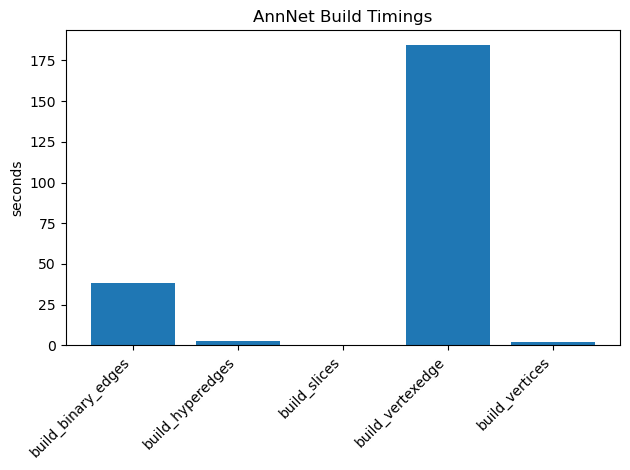

In [ ]:
fullrun("STRESS")